# Введение в глубинное обучение, ФКН ВШЭ

## Домашнее задание 3. Обработка текстов.

### Общая информация

Дата выдачи: 13.01.2022

Мягкий дедлайн: 23:59MSK 6.02.2022

Жесткий дедлайн: 23:59MSK 10.02.2022

Оценка после штрафа после мягкого дедлайна вычисляется по формуле $M_{penalty} = M_{full} \cdot 0.85^{t/1440}$, где $M_{full}$ — полная оценка за работу без учета штрафа, а $t$ — время в минутах, прошедшее после мягкого дедлайна (округление до двух цифр после запятой). Таким образом, спустя первые сутки после мягкого дедлайна вы не можете получить оценку выше 8.5, а если сдать перед самым жестким дедлайном, то ваш максимум — 5.22 балла.

### Оценивание и штрафы

Максимально допустимая оценка за работу — 10 баллов. Сдавать задание после указанного срока сдачи нельзя.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов. Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке. Также оценка может быть снижена за плохо читаемый код и плохо оформленные графики. Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.

### О задании

В данном домашнем задании вам предстоит предсказывать пользовательскую оценку отеля по тексту отзыва. Нужно обучиться на данных с кэггла и заслать в [соревнование](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) предикт. По той же ссылке можете скачать данные.

Мы собрали для вас отзывы по 1500 отелям из совершенно разных уголков мира. Что это за отели - секрет. Вам дан текст отзыва и пользовательская оценка отеля. Ваша задача - научиться предсказывать оценку отеля по отзыву.

Главная метрика - Mean Absolute Error (MAE). Во всех частях домашней работы вам нужно получить значение MAE не превышающее 0.92 на публичном лидерборде. В противном случае мы будем вынуждены не засчитать задание :( 

#### Про данные:
Каждое ревью состоит из двух текстов: positive и negative - плюсы и минусы отеля. В столбце score находится оценка пользователя - вещественное число 0 до 10. Вам нужно извлечь признаки из этих текстов и предсказать по ним оценку.

Для локального тестирования используйте предоставленное разбиение на трейн и тест.

Good luck & have fun! 💪

#### Использовать любые данные для обучения кроме предоставленных организаторами строго запрещено. В последней части можно использовать предобученные модели из библиотеки `transformers`.

In [6]:
PATH_TO_TRAIN_DATA = 'data/train.csv'
PATH_TO_TEST_DATA = 'data/test.csv'
OUT_PATH = 'data/out.csv'

In [7]:
from google.colab import drive
drive.mount('/content/drive')
PATH_TO_TRAIN_DATA = '/content/drive/MyDrive/data/train.csv'
PATH_TO_TEST_DATA = '/content/drive/MyDrive/data/test.csv'
OUT_PATH = '/content/drive/MyDrive/data/out.csv'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import StandardScaler
import numpy as np
from scipy.sparse import hstack

df = pd.read_csv(PATH_TO_TRAIN_DATA)
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,There were issues with the wifi connection,No Positive,7.1
1,00004d18f186bf2489590dc415876f73,TV not working,No Positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,More pillows,Beautiful room Great location Lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,Very business,Location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,Rooms could do with a bit of a refurbishment ...,Nice breakfast handy for Victoria train stati...,6.7


Предобработка текста может сказываться на качестве вашей модели.
Сделаем небольшой препроцессинг текстов: удалим знаки препинания, приведем все слова к нижнему регистру. 
Однако можно не ограничиваться этим набором преобразований. Подумайте, что еще можно сделать с текстами, чтобы помочь будущим моделям? Добавьте преобразования, которые могли бы помочь по вашему мнению.

Также мы добавили разбиение текстов на токены. Теперь каждая строка-ревью стала массивом токенов.

In [9]:
import string

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split

nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()
def process_text(text):
    text = list(filter(str.isalpha, word_tokenize(text.lower())))
    text = list(lemmatizer.lemmatize(word) for word in text)
    text = list(word for word in text if word not in stop_words)
    return ' '.join(text)

def process_text_v2(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation] + ['<end>']

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


### Часть 1. 1 балл

In [10]:
df['negative'] = df['negative'].apply(process_text)
df['positive'] = df['positive'].apply(process_text)

In [11]:
df_train, df_test = train_test_split(df, random_state=1412) # <- для локального тестирования

In [12]:
df.head()

,review_id,negative,positive,score
0,00003c6036f30f590c0ac435efb8739b,issue wifi connection,positive,7.1
1,00004d18f186bf2489590dc415876f73,tv working,positive,7.5
2,0000cf900cbb8667fad33a717e9b1cf4,pillow,beautiful room great location lovely staff,10.0
3,0000df16edf19e7ad9dd8c5cd6f6925e,business,location,5.4
4,00025e1aa3ac32edb496db49e76bbd00,room could bit refurbishment could corridor le...,nice breakfast handy victoria train station si...,6.7


Обучите логистическую или линейную регрессию на TF-IDF векторах текстов.

In [13]:
ss = StandardScaler()
ss.fit(df_train[['score']])
df_train['normalized_score'] = ss.transform(df_train[['score']])

In [14]:
negative_transformer = TfidfVectorizer().fit(df_train['negative'])
train_negative = negative_transformer.transform(df_train['negative'])
test_negative = negative_transformer.transform(df_test['negative'])
positive_transformer = TfidfVectorizer().fit(df_train['positive'])
train_positive = positive_transformer.transform(df_train['positive'])
test_positive = positive_transformer.transform(df_test['positive'])

train = hstack([train_negative, train_positive])
test = hstack([test_negative, test_positive])

In [15]:
lin_regr = Ridge().fit(train, df_train['normalized_score'])

In [16]:
print(f'Train acc: {mean_absolute_error(df_train["score"], ss.inverse_transform([lin_regr.predict(train)]).flatten()):.4f}')
print(f'Test acc: {mean_absolute_error(df_test["score"], ss.inverse_transform([lin_regr.predict(test)]).flatten()):.4f}')

Train acc: 0.7171
Test acc: 0.8440


In [17]:
kaggle_test = pd.read_csv(PATH_TO_TEST_DATA)
kaggle_test['negative'] = kaggle_test['negative'].apply(process_text)
kaggle_test['positive'] = kaggle_test['positive'].apply(process_text)
kaggle_test.head()

,review_id,negative,positive
0,00026f564b258ad5159aab07c357c4ca,location everything else wa horrible staff rud...,location
1,000278c73da08f4fcb857fcfe4ac6417,uk tv wa minor point watch tv although catch n...,great location comfortable clean breakfast wa ...
2,000404f843e756fe3b2a477dbefa5bd4,tiny noisy room deceptively photographed,breakfast booked preceding night forgotten wa ...
3,000a66d32bcf305148d789ac156dd512,noisy various electrical device kicking random...,great location nice bathroom
4,000bf1d8c5110701f459ffbedbf0d546,negative,great location friendly staff


In [18]:
negative_transformer = TfidfVectorizer().fit(df['negative'])
train_negative = negative_transformer.transform(df['negative'])
test_negative = negative_transformer.transform(kaggle_test['negative'])
positive_transformer = TfidfVectorizer().fit(df['positive'])
train_positive = positive_transformer.transform(df['positive'])
test_positive = positive_transformer.transform(kaggle_test['positive'])

train = hstack([train_negative, train_positive])
test = hstack([test_negative, test_positive])

ss = StandardScaler()
ss.fit(df[['score']])
df['normalized_score'] = ss.transform(df[['score']])

In [19]:
lin_regr = Ridge().fit(train, df['normalized_score'])

In [20]:
print(f'Train acc: {mean_absolute_error(df["score"], ss.inverse_transform([lin_regr.predict(train)]).flatten()):.4f}')
kaggle_output = pd.DataFrame(kaggle_test['review_id'])
kaggle_output['score'] = ss.inverse_transform([lin_regr.predict(test)]).flatten()
kaggle_output.to_csv(OUT_PATH, index=False)

Train acc: 0.7275


Предскажите этой моделью тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

Скор < 0.85

![sub_3](kaggle_submition_1_task.png)

### Часть 2. 2 балла

#### Вывод: я лолскил 

Обучите логистическую или линейную регрессию на усредненных Word2Vec векторах. 

In [ ]:
from gensim.sklearn_api import W2VTransformer

In [ ]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
df['negative'] = df['negative'].apply(process_text_v2)
df['positive'] = df['positive'].apply(process_text_v2)

KeyboardInterrupt: ignored

In [ ]:
w2v = W2VTransformer(min_count=1).fit(df['negative'])
w2v.transform(df['negative'])

NameError: ignored

Усредняя w2v вектора, мы предполагаем, что каждое слово имеет равноценный вклад в смысл предложения, однако это может быть не совсем так. Теперь попробуйте воспользоваться другой концепцией и перевзвесить слова при получении итогового эмбеддинга текста. В качестве весов используйте IDF (Inverse document frequency)

In [ ]:
def calc_idf(texts):
    pass

Проведите эксперименты с размерностью эмбеддинга. Для каждого из двух методов постройте график зависимости качества модели от размерности эмбеддинга. 

##### Сделайте выводы:

Теперь попробуйте обучить логистическую или линейную регрессию на любых других эмбеддингах размерности 300 и сравните качество с Word2Vec.
##### Выводы:
`<ВАШ ТЕКСТ ЗДЕСЬ>`

Предскажите вашей лучшей моделью из этого задания тестовые данные из [соревнования](https://www.kaggle.com/t/3e8fa6cec6d048bf8e93fb72e441d88c) и сделайте сабмит. Какой у вас получился скор? Прикрепите скриншот из кэггла.

### Часть 3. 4 балла

Теперь давайте воспользуемся более продвинутыми методами обработки текстовых данных, которые мы проходили в нашем курсе. Обучите RNN/Transformer для предсказания пользовательской оценки.

Если будете обучать RNN, попробуйте ограничить максимальную длину предложения. Некоторые отзывы могут быть слишком длинные относительно остальных.

Чтобы пользоваться DataLoader, все его элементы должны быть одинаковой размерности. Для этого вы можете добавить нулевой паддинг ко всем предложениям (см пример pad_sequence)

#### Подготовка данных

In [21]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence, pad_sequence

end_symbol = '<end>'
max_count_words = 10
def process_text_v3(text):
    return [word for word in word_tokenize(text.lower()) if word not in string.punctuation][:max_count_words] + [end_symbol]

In [22]:
df = pd.read_csv(PATH_TO_TRAIN_DATA)
def apply_process_text_v3(df):
    end_symbol = '<end_neg>'
    df['negative'] = df['negative'].apply(process_text_v3)
    end_symbol = '<end_pos>'
    df['positive'] = df['positive'].apply(process_text_v3)
    return df

In [23]:
df = apply_process_text_v3(df)

In [24]:
kaggle_test = pd.read_csv(PATH_TO_TEST_DATA)

In [25]:
WORDS = set()
for sent in list(df['positive']):
    for w in sent:
        WORDS.add(w)
        
for sent in list(df['negative']):
    for w in sent:
        WORDS.add(w)

In [26]:
int2word = dict(enumerate(tuple(WORDS)))
word2int = {w: ii for ii, w in int2word.items()}

In [27]:
MAX_LEN = max(max((df['positive'] + df['negative']).apply(len)),
              max((kaggle_test['positive'] + kaggle_test['negative']).apply(len)))

In [28]:
def get_pad(column):
    sents = [torch.as_tensor([word2int[w] for w in seq][:MAX_LEN]) for seq in column]
    lengths = torch.Tensor([len(sent) for sent in sents])
    sents[0] = nn.ConstantPad1d((0, MAX_LEN - sents[0].shape[0]), 0)(sents[0])
    return pad_sequence(sents, batch_first=True), lengths

class ReviewsDataset(torch.utils.data.Dataset):
    def __init__(self, df):
        self.data, lengths = get_pad(df['positive'] + df['negative'])
        self.lengths = torch.Tensor(lengths).reshape(-1,1)
        self.score = torch.Tensor(df['score'].values).reshape(-1,1) if 'score' in df.columns else None

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], self.lengths[idx], None if self.score is None else self.score[idx]

In [29]:
BATCH_SIZE = 32

df_train, df_test = train_test_split(df, random_state=1412)
train_dataset = ReviewsDataset(df_train)
test_dataset = ReviewsDataset(df_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

#### Неудачная попытка в рнн

##### Модель и тренер

In [30]:
# from 2nd homework
import random
from IPython.display import clear_output
import matplotlib.pyplot as plt
from copy import deepcopy
from tqdm.notebook import tqdm

def set_random_seed(seed):
    torch.backends.cudnn.deterministic = True
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

def plot_losses(train_losses, test_losses, epoch_starts, epoch_ends):
    clear_output()
    fig, ax = plt.subplots(figsize=(16, 4))
    ax.plot(range(epoch_starts, epoch_ends + 1), train_losses, label='train')
    ax.plot(range(epoch_starts, epoch_ends + 1), test_losses, label='test')
    ax.set_ylabel('loss')
    ax.grid()
    ax.set_xlabel('epoch')
    ax.legend()
    plt.show()

class GradTrainer:
    def __init__(self, model, device, optimizer, criterion,
                 scheduler=None, cnt_epochs=2, is_lr_const=False, lr_const=5e-3):
        self.model = model
        self.optimizer = optimizer
        self.criterion = criterion
        self.device = device
        self.scheduler = scheduler
        self.clear_data()
        self.epoch = 1
        self.start_epoch = 1
        self.end_epoch = cnt_epochs
        self.is_lr_const = is_lr_const
        self.lr_const = lr_const
        self.best_loss = 1000.
        self.best_model = deepcopy(self.model)
    

    def _save_if_best(self):
        if self.test_losses[-1] < self.best_loss:
            self.best_loss = self.test_losses[-1]
            self.best_model = deepcopy(self.model)


    def _drop(array_1, array_2):
        array_1 = []
        array_2 = []

    
    def make_plot_over_epochs(self, ax, train, test, name):
        if len(train) == len(test):
            GradTrainer._drop(train, test)

        rang = range(1, self.epoch + 1)
        if len(rang) != len(test):
            rang = range(1, len(test) + 1)
        ax.plot(rang, train, label='train')
        ax.plot(rang, test, label='test')
        ax.set_title(name + ' over epochs')
        ax.set_ylabel(name)
        ax.grid()
        ax.set_xlabel('epoch')
        ax.legend()
        return ax

    
    def plot_losses(self):
        clear_output()
        _, axs = plt.subplots(1, 1, figsize=(16, 8))
        self.make_plot_over_epochs(axs, self.train_losses, self.test_losses, 'Loss')
        plt.show()
        

    def clear_data(self):
        self.train_losses = []
        self.test_losses = []


    def _save_loss(self, loss, predicted_labels, true_labels, is_train=False):                              
        if is_train:
            self.train_losses += [loss]
            return

        self.test_losses += [loss]

        
    def _train_predict(self, data, lengths, labels):
        if self.is_lr_const:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr_const)
        self.optimizer.zero_grad()
        outputs = self.model(data, lengths)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return outputs, loss


    def _test_predict(self, data, lengths, labels):
        with torch.no_grad():
            outputs = self.model(data, lengths)
            loss = self.criterion(outputs, labels)
        return outputs, loss


    def _train_or_test(self, loader, is_train=False, is_saving=True):
        true_labels = torch.Tensor().to(self.device)
        predicted = torch.Tensor().to(self.device)
        name = 'Training' if is_train else 'Testing'
        running_loss = 0.0
        for data, lengths, labels in tqdm(loader, desc=name + f' {self.epoch}/{self.end_epoch}'):
            data = data.to(self.device)
            labels = labels.to(self.device)
            true_labels = torch.cat((true_labels, labels))

            outputs, loss = self._train_predict(data, lengths, labels) if\
                is_train else self._test_predict(data, lengths, labels)

            predicted = torch.cat((predicted, outputs))

            if loss.item() != np.inf:
                running_loss += loss.item() * data.shape[0]

        loss = running_loss / len(loader.dataset)
        
        if is_saving:
            self._save_loss(loss, predicted, true_labels, is_train)

        return loss, predicted, true_labels
    

    def predict(self, loader):
        predicted = torch.Tensor().to(self.device)
        for data, lengths, _ in loader:
            data = data.to(self.device)
            with torch.no_grad():
                outputs = self.best_model(data, lengths)
            predicted = torch.cat((predicted, outputs))
        return predicted


    def train(self, data_loader):
        return self._train_or_test(data_loader, is_train=True)
    

    def test(self, data_loader, is_saving=False):
        return self._train_or_test(data_loader, is_train=False, is_saving=is_saving)


    def test_and_train_once(self, train_loader, test_loader):
        self.train(train_loader)
        self.test(test_loader, is_saving=True)
        self._save_if_best()
        if self.scheduler is not None:
            self.scheduler.step()


    def do_test_and_train(self, train_loader, test_loader):
        if self.start_epoch > self.end_epoch:
            return
        for self.epoch in range(self.start_epoch, self.end_epoch + 1):
            self.test_and_train_once(train_loader, test_loader)
            self.plot_losses()
            if self.is_lr_const and len(self.train_losses) > 1:
                self.is_lr_const = (self.train_losses[-2] > self.train_losses[-1] or
                                    self.train_losses[-1] < 1.5)

        self.start_epoch = self.end_epoch + 1

In [ ]:
class RNNScoreEstimator(nn.Module):
    def __init__(self, num_embeddings, inp_size=MAX_LEN, rnn_output_size=20, hidden=20):
        super().__init__()
        self.inp_size = inp_size
        self.embedding = nn.Embedding(num_embeddings=num_embeddings, embedding_dim=inp_size)
        self.rnn = nn.RNN(input_size=inp_size, hidden_size=rnn_output_size, batch_first=True)
        self.fully_connected = nn.Sequential(
           nn.Linear(rnn_output_size, hidden),
           nn.ReLU(),
           nn.Linear(hidden, 1),
        )


    def forward(self, data, lengths):
        embeds = self.embedding(data)
        packed_embeds = pack_padded_sequence(embeds, lengths[:, 0], batch_first=True, enforce_sorted=False)
        outputs, _ = self.rnn(packed_embeds)
        outputs, lengths = pad_packed_sequence(outputs, batch_first=True)
        logits = self.fully_connected(outputs[:, -1, :])
        return logits

##### Тестирование

In [ ]:
NUM_EPOCHS = 3
set_random_seed(991)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = RNNScoreEstimator(train_dataset.data.max() + 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=5e-4)
criterion = nn.L1Loss()
scheduler = None
trainer = GradTrainer(model, device, optimizer, criterion, scheduler, cnt_epochs=NUM_EPOCHS)

In [ ]:
trainer.do_test_and_train(train_dataloader, test_dataloader)

Training 1/3:   0%|          | 0/2344 [00:00<?, ?it/s]

KeyboardInterrupt: ignored

In [ ]:
train = mean_absolute_error(ss.inverse_transform(np.array(df_train['score']).reshape(-1, 1)),
                            ss.inverse_transform(trainer.predict(train_dataloader).cpu().reshape(-1, 1)))
test = mean_absolute_error(ss.inverse_transform(np.array(df_test['score']).reshape(-1, 1)),
                           ss.inverse_transform(trainer.predict(test_dataloader).cpu().reshape(-1, 1)))

KeyboardInterrupt: ignored

In [ ]:
print(f'Train acc: {train:.4f}')
print(f'Test acc: {test:.4f}')

Я пытался рнн-кой. Но увы и ах. Качество лучше 1.28 не получилось

#### Бабушка трансформер

##### Подготовка данных (через трансформер)


In [32]:
!pip install sentence_transformers

     |████████████████████████████████| 78 kB 7.5 MB/s 
     |████████████████████████████████| 3.5 MB 67.7 MB/s 
     |████████████████████████████████| 6.8 MB 58.2 MB/s 
     |████████████████████████████████| 1.2 MB 57.6 MB/s 
     |████████████████████████████████| 67 kB 7.4 MB/s 
     |████████████████████████████████| 895 kB 54.6 MB/s 
     |████████████████████████████████| 596 kB 74.5 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.1.0-py3-none-any.whl size=120999 sha256=e1de7866e46825b271009b341839af440da8f42750d209a4585036c841d549a5
  Stored in directory: /root/.cache/pip/wheels/90/f0/bb/ed1add84da70092ea526466eadc2bfb197c4bcb8d4fa5f7bad
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


In [ ]:
from sentence_transformers import SentenceTransformer
transformer = SentenceTransformer('paraphrase-MiniLM-L6-v2')

df = pd.read_csv(PATH_TO_TRAIN_DATA)
embeddings_pos = transformer.encode(df['positive'])
embeddings_neg = transformer.encode(df['negative'])

In [ ]:
X = torch.cat((torch.Tensor(embeddings_pos), torch.Tensor(embeddings_neg)), dim=1)
ss = StandardScaler()
ss.fit(df[['score']])
y = torch.Tensor(ss.transform(df[['score']]))
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1412)

In [ ]:
kaggle_test = pd.read_csv(PATH_TO_TEST_DATA)
embeddings_pos = transformer.encode(kaggle_test['positive'])
embeddings_neg = transformer.encode(kaggle_test['negative'])
kaggle_X = torch.cat((torch.Tensor(embeddings_pos), torch.Tensor(embeddings_neg)), dim=1)

Просто фан проверочка риджем.

In [37]:
ridge = Ridge() # simple linear layer after transforming
ridge.fit(X_train, y_train)
print(f'Train acc: {mean_absolute_error(ss.inverse_transform(y_train), ss.inverse_transform(ridge.predict(X_train)).flatten()):.4f}')
print(f'Test acc: {mean_absolute_error(ss.inverse_transform(y_test), ss.inverse_transform(ridge.predict(X_test)).flatten()):.4f}')

Train acc: 0.8404
Test acc: 0.8581


##### Вспомогательные функции и классы для трансформера

In [65]:
class TransformerDataset(torch.utils.data.Dataset):
    def __init__(self, X, y=None):
        self.data = X
        self.score = y

    def __len__(self):
        return self.data.shape[0]
    
    def __getitem__(self, idx):
        return self.data[idx], 0. if self.score is None else self.score[idx]


class TranformerTrainer(GradTrainer):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)

    def _train_predict(self, data, labels):
        if self.is_lr_const:
            self.optimizer = torch.optim.Adam(self.model.parameters(), lr=self.lr_const)
        self.optimizer.zero_grad()
        outputs = self.model(data)
        loss = self.criterion(outputs, labels)
        loss.backward()
        self.optimizer.step()
        return outputs, loss


    def _test_predict(self, data, labels):
        with torch.no_grad():
            outputs = self.model(data)
            loss = self.criterion(outputs, labels)
        return outputs, loss


    def _train_or_test(self, loader, is_train=False, is_saving=True):
        true_labels = torch.Tensor().to(self.device)
        predicted = torch.Tensor().to(self.device)
        name = 'Training' if is_train else 'Testing'
        if is_train:
            self.model.train()
        else:
            self.model.eval()

        running_loss = 0.0
        for data, labels in tqdm(loader, desc=name + f' {self.epoch}/{self.end_epoch}'):
            data = data.to(self.device)
            labels = labels.to(self.device)
            true_labels = torch.cat((true_labels, labels))

            outputs, loss = self._train_predict(data, labels) if\
                is_train else self._test_predict(data, labels)

            predicted = torch.cat((predicted, outputs))

            if loss.item() != np.inf:
                running_loss += loss.item() * data.shape[0]

        loss = running_loss / len(loader.dataset)        
        if is_saving:
            self._save_loss(loss, predicted, true_labels, is_train)

        return loss, predicted, true_labels


    def last_predict(self, loader):
        self.model.eval()
        predicted = torch.Tensor().to(self.device)
        for data, _ in loader:
            data = data.to(self.device)
            with torch.no_grad():
                outputs = self.model(data)
            predicted = torch.cat((predicted, outputs))

        return predicted
    
    def predict(self, loader):
        self.best_model.eval()
        predicted = torch.Tensor().to(self.device)
        for data, _ in loader:
            data = data.to(self.device)
            with torch.no_grad():
                outputs = self.best_model(data)
            predicted = torch.cat((predicted, outputs))

        return predicted


class TransformerScoreEstimator(nn.Module):
    def __init__(self, hidden_1_size=64, hidden_2_size=32, input_size=768):
        super().__init__()
        self.out = nn.Sequential(
           nn.Linear(input_size, hidden_1_size),
           nn.ReLU(),
           nn.Linear(hidden_1_size, hidden_2_size),
           nn.ReLU(),
           nn.Linear(hidden_2_size, 1),
        )


    def forward(self, data):
        logits = self.out(data)
        return logits

##### Тест трансформера

In [75]:
BATCH_SIZE = 16

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.02, random_state=1412)
train_dataset = TransformerDataset(X_train, y_train)
test_dataset = TransformerDataset(X_test, y_test)

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE)

In [76]:
res_dataset = TransformerDataset(kaggle_X)
res_dataloader = torch.utils.data.DataLoader(res_dataset, batch_size=BATCH_SIZE)

Обработаем данные для kaggle

In [78]:
NUM_EPOCHS = 10
set_random_seed(997)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = TransformerScoreEstimator(128, 64).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
criterion = nn.L1Loss()
scheduler = None
trainer = TranformerTrainer(model, device, optimizer, criterion, scheduler, cnt_epochs=NUM_EPOCHS)

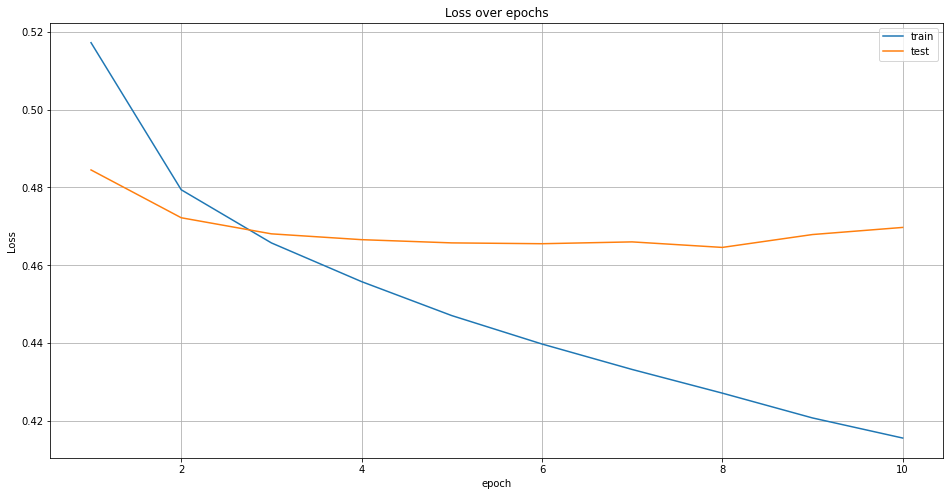

In [79]:
trainer.do_test_and_train(train_dataloader, test_dataloader)

In [80]:
train = trainer.predict(train_dataloader)
test = trainer.predict(test_dataloader)

train = mean_absolute_error(ss.inverse_transform(np.array(y_train).reshape(-1, 1)),
                            ss.inverse_transform(train.cpu().reshape(-1, 1)))
test = mean_absolute_error(ss.inverse_transform(np.array(y_test).reshape(-1, 1)),
                           ss.inverse_transform(test.cpu().reshape(-1, 1)))

print(f'Train acc: {train:.4f}')
print(f'Test acc: {test:.4f}')

Train acc: 0.6885
Test acc: 0.7615


##### Результат трансформера

In [81]:
result = trainer.predict(res_dataloader).cpu()

In [82]:
kaggle_output = pd.DataFrame(kaggle_test['review_id'])
kaggle_output['score'] = ss.inverse_transform(result).flatten()
kaggle_output.to_csv(OUT_PATH, index=False)

### Контест (до 3 баллов)

По итогам всех ваших экспериментов выберите модель, которую считаете лучшей. Сделайте сабмит в контест. В зависимости от вашего скора на публичном лидерборде, мы начислим вам баллы:

 - <0.76 - 3 балла
 - [0.76; 0.78) - 2 балла
 - [0.78; 0.8) - 1 балл

Было много попыток, но все лучшие попали в диапозон 2 баллов (0.77041 лучшая была кажется)

![sub_3](kaggle_sub_3.png)